## An Information-Theoretic Approach to Explainable Machine Learning 
Alexander Jung
Aalto University 

This notebook contains the numerical experiments of the paper https://arxiv.org/abs/2003.00484

The code snippet below reads in a small region of the city map of Helsinki. 

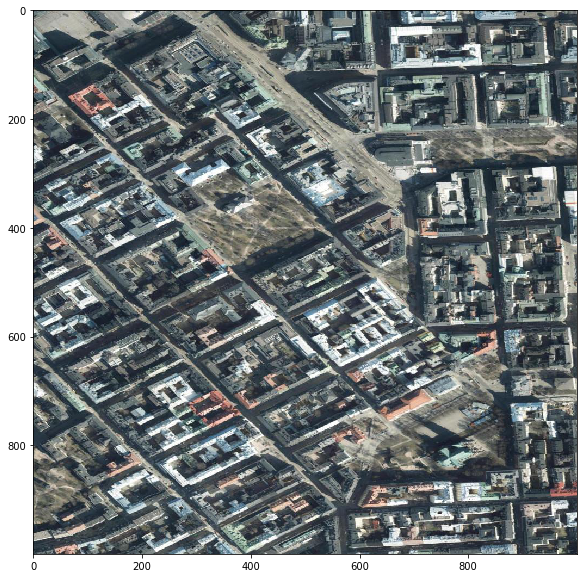

In [32]:
# import "Pandas" library/package (and use shorthand "pd" for the package) 
# Pandas provides functions for loading (storing) data from (to) files
import pandas as pd  
# the library "cv2" provides powerful methods for image processing and computer vision
import cv2 
# import functions for displaying and plotting data 
from matplotlib import pyplot as plt 
from IPython.display import display, HTML
# library "numpy" provides matrix (represented by numpy arrays) operations 
import numpy as np   
# library "random" provides functions for generating random numbers
import random

# the library owslib provides functions for accessing geospatial (location) information and services (like kartta.hel.fi)
from owslib.wms import WebMapService # import WebMapService from library owalib.wms
# the library io provides functions for handling data in the form of bitstreams ("raw" data)
import io                            # import library io
# the library matplotlib.pyplot provides functions for plotting data 
# The Python Imaging Library (PIL) provides helpful functions for image processing 
from PIL import Image
from numpy import linalg as LA

wms = WebMapService('https://kartta.hel.fi/ws/geoserver/avoindata/wms', version='1.1.1') # get the helsinki map

cs = 'EPSG:4326'  # select the coordinate system to be used 

# specify region of Helsinki city area

xmin = 24.92      # x-coordinate of bottom-left corner 
ymin = 60.15      # y-coordinate of bottom-left corner 
xmax = 24.99      # x-coordinate of upper-right corner
ymax = 60.20      # y-coordinate of upper-right corner

# divide Helsinki area into 50 by 50 patches
nr_patches_x = 5 
nr_patches_y = 5 

# determine dimensions of one single patch
patch_x = (xmax-xmin)/nr_patches_x  
patch_y = (ymax-ymin)/nr_patches_y

# choose one particular patch and determine the corresponding bounding box 
nr_x = 1
nr_y = 1
patch_box = (xmin+nr_x*patch_x,ymin+nr_y*patch_y,xmin+(nr_x+1)*patch_x,ymin+(nr_y+1)*patch_y) 

# choose a layer from the map service (for a list of available layers visit https://kartta.hel.fi)
ortholayer = 'avoindata:Ortoilmakuva_2019_5cm' 
buildingmap = 'avoindata:Karttasarja'
# set the resolution in number of pixels used in each direction 
res = (1000,1000) 
img = wms.getmap(layers=[ortholayer],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True) # get the image based on patch parameters (see above linked documentation for more details)
# convert the raw image data into an image object 
pic = Image.open(io.BytesIO(img.read())) 
# initialize a plot figure of size 10 x 10 inches
fig = plt.figure(figsize=(10,10))  
plt.imshow(pic)
# display the plot
plt.show()

The code snippet below constructs training data. The data points represent individual pixels whose label is the greyscale value of the center pixel and the features are grayscale values of near-by pixels. Features are stored in the rows of numpy array `X` of shape (m,n) and labels are stored in numpy array `y`of shape (m,1). The user summaries are stored in numpy array `u` of shape (m,1). 

In [33]:

# convert iamge object into a numpy array 
X = np.array(pic, dtype='uint8') 
X=LA.norm(X, axis=2)
#corrupted = 'PhotoHelsinki.bmp'
#Photo = cv2.imread(corrupted, 0)
#Photo = cv2.resize(Photo, (100, 100))

Photo = X.astype(float)
imgwidth = Photo.shape[0]
imgheight = Photo.shape[1]
    
# define size of neighborhood which is used to characterize a pixel
wp = 2
hp = 2
        
# determine "uncorroputed pixels" by finding those pixels with grayscale value larger than 0
#good_idx = np.where(Photo > 0)
    
# avoid pixels close to the boundary since we cannot find neighouring pixels for them 
rows = np.clip(range(imgwidth) , wp, imgheight - wp)
cols = np.clip(range(imgheight), hp, imgwidth - hp)
    
# the function cv2.imread() returns an array of grayscale values 0...255 stored as integers 
# it will be convenient to convert the integers to floating point numbers 
# this allows us to work with grayscale values as real numbers 
Photo = Photo.astype(float)
samplesize = rows.shape[0]
    
# augment image in Data with stripes such that we can also define neighborhoods of border pixels 
tmp = np.vstack((np.zeros((wp,imgwidth)),Photo,np.zeros((wp,imgwidth))))
augmented = np.hstack((np.zeros((2*wp+imgheight,hp)),tmp,np.zeros((2*wp+imgheight,hp))))
    
# construct features X for and label vector y for training 
# x1 = np.zeros((samplesize,1))
y = np.zeros((samplesize,1))  # predictions on training set 
u = np.zeros((samplesize,1))  # user summary
m = 1000 
n = 10 
X = np.zeros((m,2*wp*(2*hp+1))) # features of data points in training set 

for iter_datapoint in range(m):
    row_tmp = rows[iter_datapoint]+wp
    col_tmp = cols[iter_datapoint]+hp
        # the feature of a data point (pixel) is the average gray level of the neighborhoud 
  #  x1[iter_datapoint] = np.sum(augmented[(row_tmp-wp):(row_tmp),(col_tmp-hp):(col_tmp+hp+1)])/(wp*(2*hp+1))
    tmp = np.vstack((augmented[(row_tmp-wp):(row_tmp),(col_tmp-hp):(col_tmp+hp+1)],augmented[(row_tmp+1):(row_tmp+wp+1),(col_tmp-hp):(col_tmp+hp+1)]))
    X[iter_datapoint,:] = tmp.reshape(1,-1)
    u[iter_datapoint] = np.sum(tmp)/(2*wp*(2*hp+1))
    y[iter_datapoint] = augmented[row_tmp,col_tmp]

print(u)
#x1 = x1[0:m]
# lets add some "extra features" here 
#X = np.hstack((x1,np.random.randn(n,m).T)) 
    
#X = X[:,0:n] 
y = y[0:m]

[[185.63905075]
 [185.63905075]
 [185.63905075]
 [185.86642099]
 [196.25407859]
 [201.10372133]
 [201.17162595]
 [203.78492754]
 [216.99429758]
 [224.85470471]
 [225.40957184]
 [244.5003302 ]
 [241.47895902]
 [242.36100239]
 [245.86169384]
 [246.12791076]
 [256.08546892]
 [262.70742262]
 [269.83412053]
 [272.34522482]
 [276.06860446]
 [280.31155749]
 [280.65792354]
 [279.09928878]
 [280.8311247 ]
 [281.69703454]
 [284.81432385]
 [290.52937633]
 [297.28356512]
 [303.34504162]
 [302.90057623]
 [298.37429323]
 [297.97183945]
 [299.8838652 ]
 [302.28381252]
 [293.39635537]
 [262.32519898]
 [210.81672197]
 [152.87982439]
 [117.19980559]
 [107.9184752 ]
 [105.23449703]
 [101.49987984]
 [100.90499712]
 [ 99.94985151]
 [ 99.2485754 ]
 [ 98.87326278]
 [ 96.78642967]
 [ 94.99715244]
 [ 95.03844846]
 [ 94.68446705]
 [ 93.83605747]
 [ 92.48068054]
 [ 90.78933198]
 [ 90.11403401]
 [ 88.84553527]
 [ 87.49097735]
 [ 86.05450711]
 [ 84.70424009]
 [ 83.52472799]
 [ 82.43181016]
 [ 81.50752907]
 [ 81.14

[ 0.0164192   0.07666748 -0.25432022  0.127762   -0.13221227 -0.08130105
  0.12239104  0.52310417 -0.0977743   0.18686599 -0.00600918  0.11418061
  0.48963518  0.0507477   0.01136292  0.11238511 -0.13458914 -0.14947494
  0.01825844  0.00720107]


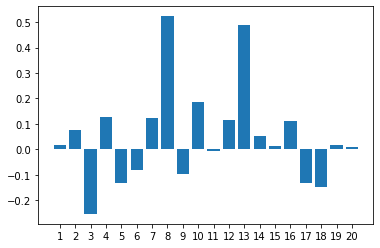

[ 1.21657425e+10  1.21657425e+10  1.21657425e+10  1.21657425e+10
  1.21657425e+10  1.21657425e+10  1.21657425e+10  1.21657425e+10
  1.21657425e+10  1.21657425e+10  1.21657425e+10  1.21657425e+10
  1.21657425e+10  1.21657425e+10  1.21657425e+10  1.21657425e+10
  1.21657425e+10  1.21657425e+10  1.21657425e+10  1.21657425e+10
 -2.43314849e+11]


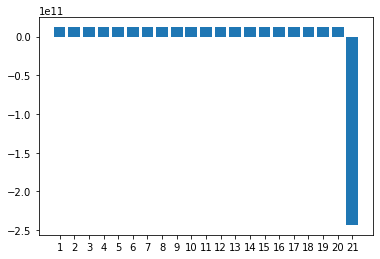

In [34]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

linreg = LinearRegression()
linreg.fit(X,y)
weights = linreg.coef_[0]
print(weights)
ind = np.arange(weights.shape[0])
p1 = plt.bar(ind+1, weights)
plt.xticks(ind+1)
plt.show()

linreg.fit(np.hstack((X,u)),y)
weights_expl = linreg.coef_[0]
print(weights_expl)
ind = np.arange(weights_expl.shape[0])
p1 = plt.bar(ind+1, weights_expl)
plt.xticks(ind+1)
plt.show()
